In [1]:
# importacion de librerias

import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
tick = "ETH-USD"

In [3]:
fecha_hoy = pd.Timestamp.today().strftime('%Y-%m-%d')

In [4]:
df = yf.download(tick, start="2015-01-01", end=fecha_hoy)

[*********************100%***********************]  1 of 1 completed


In [5]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2023-07-26,1857.696533,1886.974121,1849.436890,1872.159912,1872.159912,5781548155
2023-07-27,1872.086304,1885.591553,1855.321533,1860.357178,1860.357178,4291339248
2023-07-28,1860.702515,1881.457275,1857.048950,1874.744873,1874.744873,3800973336


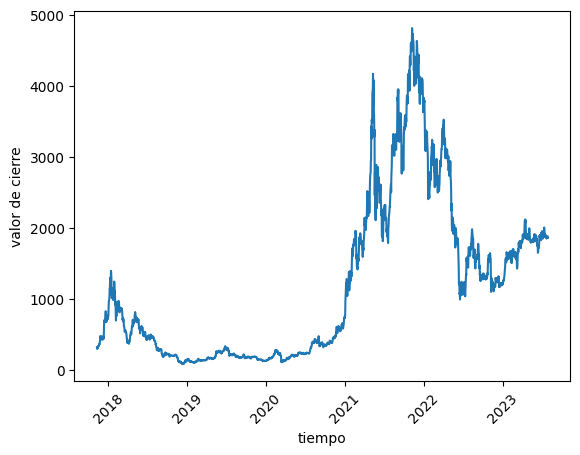

In [6]:
#grafica de como el valor de close va subiendo o bajando, basicamente el valor de la accion
plt.xlabel("tiempo")
plt.ylabel("valor de cierre")
plt.plot(df['Close'])
plt.xticks(rotation = 45)
plt.show()

In [7]:
#obtengo la diferencia de open y close
df['Open-Close'] = df.Open - df.Close
df['High-Low'] = df.High - df.Low # tambien la de high y low que es mayor y menor precio de la accion en ese dia

X = df[['Open-Close','High-Low']] #de lo anterior obtengo mis datos de input
X.head()

,Open-Close,High-Low
Date,,
2017-11-09,-12.239014,22.395996
2017-11-10,21.417999,30.175995
2017-11-11,-16.095001,21.261017
2017-11-12,6.782013,20.640015
2017-11-13,-9.691010,21.390015


In [8]:
y = np.where(df['Close'].shift(-1) > df['Close'],1,0)
type(y)

numpy.ndarray

In [9]:
#divido los datos X y "y" en entrenamiento y test
split_percentage = 0.8
split = int(split_percentage * len(df))

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

In [10]:
len(X), len(y)

(2090, 2090)

In [11]:
data = X
targets = y
lenght = 10
batch_size = 32

In [12]:
generator1 = TimeseriesGenerator(data, targets, length = lenght, batch_size=batch_size)

In [119]:
# Crear el modelo LSTM
from tensorflow.keras.layers import LSTM, Dense, Reshape
modelo = Sequential()
modelo.add(LSTM(units=32, input_shape=(lenght, 2), return_sequences=True))  # Aquí usamos 'length' como paso de tiempo y 2 característica
modelo.add(LSTM(units=32, return_sequences=True))
modelo.add(Dense(units=64,activation = 'relu'))
modelo.add(Dense(units=1, activation='sigmoid'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo utilizando el generador de secuencias
modelo.fit(generator1, epochs=10)

Epoch 1/10
65/65 [==============================] - 5s 15ms/step - loss: 0.2510
Epoch 2/10
65/65 [==============================] - 2s 23ms/step - loss: 0.2497
Epoch 3/10
65/65 [==============================] - 1s 21ms/step - loss: 0.2499
Epoch 4/10
65/65 [==============================] - 1s 14ms/step - loss: 0.2496
Epoch 5/10
65/65 [==============================] - 1s 14ms/step - loss: 0.2496
Epoch 6/10
65/65 [==============================] - 1s 14ms/step - loss: 0.2497
Epoch 7/10
65/65 [==============================] - 1s 14ms/step - loss: 0.2493
Epoch 8/10
65/65 [==============================] - 1s 14ms/step - loss: 0.2494
Epoch 9/10
65/65 [==============================] - 1s 14ms/step - loss: 0.2492
Epoch 10/10
65/65 [==============================] - 1s 14ms/step - loss: 0.2492


In [120]:
length = 10

# Tamaño del lote
batch_size = 32

# Crear el generador de secuencias para hacer predicciones
generator2 = TimeseriesGenerator(X_test, np.zeros((len(X_test),)), length=length, batch_size=batch_size)

# Hacer predicciones con el modelo
predicciones = modelo.predict(generator2)

13/13 [==============================] - 1s 6ms/step


In [121]:
predicciones_array = np.squeeze(predicciones)

In [122]:
umbral = 0.5
predicciones_binarias = (predicciones_array >= umbral).astype(int)

In [130]:
np.squeeze(predicciones_binarias)

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 1, 0, 1],
       [1, 1, 0, ..., 0, 1, 1]])

In [123]:
y_test_2 = y_test[10:]

In [124]:
import numpy as np
from sklearn.metrics import recall_score

# Supongamos que 'y_test' es el array numpy que contiene las etiquetas reales (ground truth) para las muestras de prueba
# Supongamos que 'predicciones_binarias' es un array numpy con las predicciones binarias obtenidas después de aplicar un umbral a las probabilidades

# Calcula el recall
recall = recall_score(y_test_2, predicciones_binarias)

print("Recall:", recall)


ValueError: ignored

In [94]:

# Guardar el modelo
modelo.save('modelo_LSTM.h5')

In [95]:
# Calculate daily returns
df['Return'] = df.Close.pct_change() #funcion para sacar el porcentaje de aumento o disminucion
df['Return']

Date
2017-11-19         NaN
2017-11-20    0.034832
2017-11-21   -0.017258
2017-11-22    0.056190
2017-11-23    0.077535
                ...   
2023-07-26    0.007761
2023-07-27   -0.006304
2023-07-28    0.007734
2023-07-29    0.003373
2023-07-30   -0.010327
Name: Return, Length: 2080, dtype: float64

In [96]:
df

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,Return,Predicted_Signal,Strategy_Return,Cum_Ret,Cum_Strategy
Date,,,,,,,,,,,,,
2017-11-19,347.401001,371.290985,344.739990,354.385986,354.385986,1181529984,-6.984985,26.550995,NaN,1,NaN,NaN,NaN
2017-11-20,354.093994,372.136993,353.289001,366.730011,366.730011,807027008,-12.636017,18.847992,0.034832,1,0.034832,0.034832,0.034832
2017-11-21,367.442993,372.470001,350.692993,360.401001,360.401001,949912000,7.041992,21.777008,-0.017258,1,-0.017258,0.017574,0.017574
2017-11-22,360.312012,381.420013,360.147003,380.652008,380.652008,800819008,-20.339996,21.273010,0.056190,1,0.056190,0.073764,0.073764
2017-11-23,381.438995,425.548004,376.088013,410.165985,410.165985,1845680000,-28.726990,49.459991,0.077535,1,0.077535,0.151300,0.151300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-26,1857.696533,1886.974121,1849.436890,1872.159912,1872.159912,5781548155,-14.463379,37.537231,0.007761,0,0.007761,4.173417,6.082464
2023-07-27,1872.086304,1885.591553,1855.321533,1860.357178,1860.357178,4291339248,11.729126,30.270020,-0.006304,0,-0.000000,4.167112,6.082464
2023-07-28,1860.702515,1881.457275,1857.048950,1874.744873,1874.744873,3800973336,-14.042358,24.408325,0.007734,1,0.000000,4.174846,6.082464


In [97]:
length = 10

# Tamaño del lote
batch_size = 32

# Crear el generador de secuencias para hacer predicciones
generator2 = TimeseriesGenerator(X, np.zeros((len(X),)), length=length, batch_size=batch_size)

# Hacer predicciones con el modelo
predicciones = modelo.predict(generator2)

65/65 [==============================] - 0s 5ms/step


In [98]:
predicciones_array = np.squeeze(predicciones)

In [99]:
umbral = 0.5
predicciones_binarias = (predicciones_array >= umbral).astype(int)

In [100]:
len(predicciones_binarias)

2080

In [101]:
datos_perdidos = len(y) - len(predicciones_binarias)

In [102]:
datos_perdidos

0

In [103]:
y = y[datos_perdidos:]

In [104]:
len(y)

2080

In [105]:
predicciones_binarias

array([1, 0, 1, ..., 1, 1, 0])

In [106]:
df = df[datos_perdidos:]

In [107]:
df['Predicted_Signal'] = predicciones_binarias #predigo los datos del dataframe X que antes dividi en entrenamiento y test
df['Predicted_Signal']

Date
2017-11-19    1
2017-11-20    0
2017-11-21    1
2017-11-22    1
2017-11-23    1
             ..
2023-07-26    1
2023-07-27    1
2023-07-28    1
2023-07-29    1
2023-07-30    0
Name: Predicted_Signal, Length: 2080, dtype: int64

In [108]:
df

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,Return,Predicted_Signal,Strategy_Return,Cum_Ret,Cum_Strategy
Date,,,,,,,,,,,,,
2017-11-19,347.401001,371.290985,344.739990,354.385986,354.385986,1181529984,-6.984985,26.550995,NaN,1,NaN,NaN,NaN
2017-11-20,354.093994,372.136993,353.289001,366.730011,366.730011,807027008,-12.636017,18.847992,0.034832,0,0.034832,0.034832,0.034832
2017-11-21,367.442993,372.470001,350.692993,360.401001,360.401001,949912000,7.041992,21.777008,-0.017258,1,-0.017258,0.017574,0.017574
2017-11-22,360.312012,381.420013,360.147003,380.652008,380.652008,800819008,-20.339996,21.273010,0.056190,1,0.056190,0.073764,0.073764
2017-11-23,381.438995,425.548004,376.088013,410.165985,410.165985,1845680000,-28.726990,49.459991,0.077535,1,0.077535,0.151300,0.151300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-26,1857.696533,1886.974121,1849.436890,1872.159912,1872.159912,5781548155,-14.463379,37.537231,0.007761,1,0.007761,4.173417,6.082464
2023-07-27,1872.086304,1885.591553,1855.321533,1860.357178,1860.357178,4291339248,11.729126,30.270020,-0.006304,1,-0.000000,4.167112,6.082464
2023-07-28,1860.702515,1881.457275,1857.048950,1874.744873,1874.744873,3800973336,-14.042358,24.408325,0.007734,1,0.000000,4.174846,6.082464


In [109]:
# Calculate strategy returns
df['Strategy_Return'] = df.Return *df.Predicted_Signal.shift(1)
df['Strategy_Return']

Date
2017-11-19         NaN
2017-11-20    0.034832
2017-11-21   -0.000000
2017-11-22    0.056190
2017-11-23    0.077535
                ...   
2023-07-26    0.007761
2023-07-27   -0.006304
2023-07-28    0.007734
2023-07-29    0.003373
2023-07-30   -0.010327
Name: Strategy_Return, Length: 2080, dtype: float64

In [110]:
# Calculate Cumulutive returns
df['Cum_Ret'] = df['Return'].cumsum()

# Plot Strategy Cumulative returns
df['Cum_Strategy'] = df['Strategy_Return'].cumsum()

In [111]:
df

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,Return,Predicted_Signal,Strategy_Return,Cum_Ret,Cum_Strategy
Date,,,,,,,,,,,,,
2017-11-19,347.401001,371.290985,344.739990,354.385986,354.385986,1181529984,-6.984985,26.550995,NaN,1,NaN,NaN,NaN
2017-11-20,354.093994,372.136993,353.289001,366.730011,366.730011,807027008,-12.636017,18.847992,0.034832,0,0.034832,0.034832,0.034832
2017-11-21,367.442993,372.470001,350.692993,360.401001,360.401001,949912000,7.041992,21.777008,-0.017258,1,-0.000000,0.017574,0.034832
2017-11-22,360.312012,381.420013,360.147003,380.652008,380.652008,800819008,-20.339996,21.273010,0.056190,1,0.056190,0.073764,0.091022
2017-11-23,381.438995,425.548004,376.088013,410.165985,410.165985,1845680000,-28.726990,49.459991,0.077535,1,0.077535,0.151300,0.168558
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-26,1857.696533,1886.974121,1849.436890,1872.159912,1872.159912,5781548155,-14.463379,37.537231,0.007761,1,0.007761,4.173417,8.399834
2023-07-27,1872.086304,1885.591553,1855.321533,1860.357178,1860.357178,4291339248,11.729126,30.270020,-0.006304,1,-0.006304,4.167112,8.393530
2023-07-28,1860.702515,1881.457275,1857.048950,1874.744873,1874.744873,3800973336,-14.042358,24.408325,0.007734,1,0.007734,4.174846,8.401263


(array([17167., 17532., 17897., 18262., 18628., 18993., 19358.]),
 [Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023')])

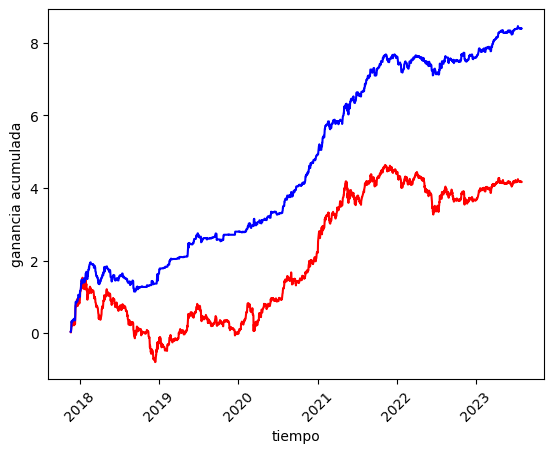

In [112]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel("tiempo")
plt.ylabel("ganancia acumulada")

plt.plot(df['Cum_Ret'],color='red')
plt.plot(df['Cum_Strategy'],color='blue')
plt.xticks(rotation = 45)